In [8]:
### imports

# external modules
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.models import load_model
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import DataLoader
importlib.reload(DataLoader)
import HistStruct
importlib.reload(HistStruct)

<module 'HistStruct' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/HistStruct.py'>

In [2]:
### Set Data Controls

year = '2017' # Data-taking year
eras = ['B'] # List of eras
dim = 1 # Dimension of histograms (1D or 2D)
# May need alteration later, but this is the only data directory I have perms for
datadir = '/eos/user/j/jmhogan/TrackerDQM/DF2017B_1D_Complete/'
outputdir = '../data/'

# For now, have the user manually select histograms
# In the future, could read all histograms from file
histnames = ([
    'NormalizedHitResiduals_TIB__Layer__1',
    'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1',
    #'NormalizedHitResiduals_TIB__Layer__2',
    #'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
    #'chargeInner_PXLayer_1',
    #'chargeInner_PXLayer_2',
    #'chargeOuter_PXLayer_1',
    #'chargeOuter_PXLayer_2'
])

print('Histograms to process: ' + str(len(histnames)))

Histograms to process: 2


In [3]:
### Read and Format CSV Files
# CSV files are formatted into CSvs with one histogram type each (with the full year's data)
# Note: This cell can take quite a while to run!

# Select whether to used previously processed data
readnew = True
save = True

# Stores our histograms in a dictionary for use
histograms = {}

# Loop over eras
for era in eras:
    print('\nBegin processing for era ' + era)
    
    # Create a DataLoader instance
    dloader = DataLoader.DataLoader()

    # Get the CSV files (if the line above is altered to be a list, remove the brackets)
    csvfiles = dloader.get_csv_files_in_dirs([datadir])
    df = dloader.get_dataframe_from_files(csvfiles, histnames = histnames)
    
    # Loop over histnames and write one file per histogram type
    for histname in histnames:
        thisdf = dfu.select_histnames(df, [histname])
        histograms[histname] = thisdf
        
        # Save the histogram for reference
        outputfile = 'DF' + year + era + '_' + histname + '.csv'
        print('Creating file ' + outputdir + outputfile)
        dloader.write_dataframe_to_file(thisdf, os.path.join(outputdir, outputfile))



Begin processing for era B
INFO in csv_utils.py / read_and_merge_csv: reading and merging 33 csv files...
  - now processing file 1 of 33...
  - now processing file 2 of 33...
  - now processing file 3 of 33...
  - now processing file 4 of 33...
  - now processing file 5 of 33...
  - now processing file 6 of 33...
  - now processing file 7 of 33...
  - now processing file 8 of 33...
  - now processing file 9 of 33...
  - now processing file 10 of 33...
  - now processing file 11 of 33...
  - now processing file 12 of 33...
  - now processing file 13 of 33...
  - now processing file 14 of 33...
  - now processing file 15 of 33...
  - now processing file 16 of 33...
  - now processing file 17 of 33...
  - now processing file 18 of 33...
  - now processing file 19 of 33...
  - now processing file 20 of 33...
  - now processing file 21 of 33...
  - now processing file 22 of 33...
  - now processing file 23 of 33...
  - now processing file 24 of 33...
  - now processing file 25 of 33...
  

In [51]:
### Filtering
for histname in histnames:
    df = histograms[histname]
    print('Processing ' + histname + ' with {} lumisections'.format(len(df)))
    df = dfu.select_dcson(df)
    print('Number of passing lumisections after DCS selection: {}'.format(len(df)))

    # Not sure what entries to bins ratio is
    df = dfu.select_highstat(df, entries_to_bins_ratio=100)
    print('Number of passing lumisections after high statistics selection: {}\n'.format(len(df)))
    histograms[histname] = df

Processing NormalizedHitResiduals_TIB__Layer__1 with 28335 lumisections
Number of passing lumisections after DCS selection: 27185
Number of passing lumisections after high statistics selection: 26975

Processing Summary_ClusterStoNCorr__OnTrack__TIB__layer__1 with 28335 lumisections
Number of passing lumisections after DCS selection: 27185
Number of passing lumisections after high statistics selection: 27044



Size of training set:(26975, 102)


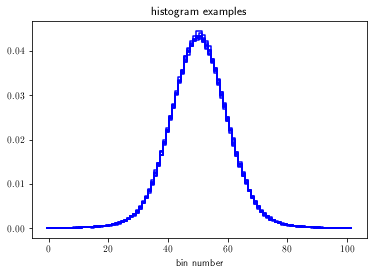

Size of training set:(27044, 102)


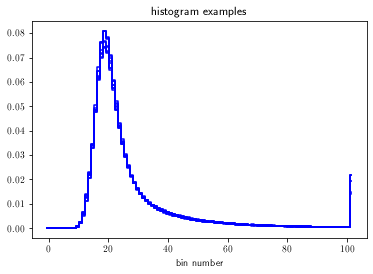

In [52]:
### Data preprocessing

# Setting a rebinning factor (I think this is multiplied/divided to bin count)
rebinningfactor = 1
X_train_list = []

# Setting up a set of training data
# Donormalize and doplot tell the function whether to normalize and plot respectively
for histname in histnames:
    df = histograms[histname]
    train_hist = hu.preparedatafromdf(df, rebinningfactor = rebinningfactor,
                              donormalize=True,doplot=True)
    X_train_list.append(train_hist)
    print('Size of training set:' + str(train_hist.shape))
    plt.show()

In [9]:
### A method to build 1D autoencoders off of subsets of the data
#
def build1DAutoencoder(hist_selections):
    
    # Setting a rebinning factor
    rebinningfactor = 1
    
    ## Data preprocessing
    
    filenames = []
    # Selects specified histograms to use in training
    for histname in histnames:
        filenames.append(outputdir + 'DF2017B_' + histname + '.csv')
        
    print(filenames)
    df = csvu.read_and_merge_csv(filenames, histnames = [], runnbs = [])

    df.loc[(df['fromrun'] == 297178) & (df['fromlumi'] == 1283)]
    df1 = dfu.merge_ls(df)
    df.reset_index(drop=True, inplace = True)
    
    df.loc[(df['fromrun'] == 297178) & (df['fromlumi'] == 1283)]
    df2 = dfu.select_runs(df,[ 
        297057, 297099, 297101, 297113, 297114, 297175, 297177, 297179, 297215, 297218, 297225, 297296, 297411, 297426, 297431, 297434, 297468, 297483, 297486, 297503, 297557, 297598, 297604, 297620, 297659, 297670, 297674, 297678, 297722, 298997, 299061, 299065, 299067, 299096, 299149, 299178, 299184, 299185, 299327, 299329, 299480])
                      #[297050,  297474,299000, 299917]
    df2 = dfu.select_dcson(df2)
    print('number of passing lumisections after DCS selection: {}'.format( len(df2) ))

    df2 = dfu.select_highstat(df2,entries_to_bins_ratio=100)
    print('number of passing lumisections after high statistics selection: {}'.format( len(df2) ))
    
    X_train = hu.preparedatafromdf(df2,rebinningfactor=rebinningfactor,donormalize=True,doplot=True)
    
    
    
    

['../data/DF2017B_NormalizedHitResiduals_TIB__Layer__1.csv', '../data/DF2017B_Summary_ClusterStoNCorr__OnTrack__TIB__layer__1.csv']
INFO in csv_utils.py / read_and_merge_csv: reading and merging 2 csv files...
  - now processing file 1 of 2...
  - now processing file 2 of 2...
INFO in csv_utils.py / read_and_merge_csv: merged 2 csv files.
number of passing lumisections after DCS selection: 21262
number of passing lumisections after high statistics selection: 21178


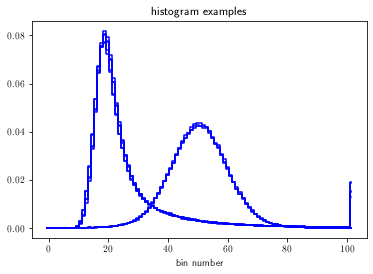

In [10]:
hist_selections = [0, 1]
build1DAutoencoder(hist_selections)
plt.show()

In [11]:
### Model creation and training

# Selection to train a new model or load a previous save
trainnew = True
savemodel = False
# Model name should follow the convention specified below
modelname = '../models/autoencoders_global_training_dcson_highstat_v20220601/_chargeInner_PXLayer_2.h5'

print(nbins)

# If training a new model
if trainnew:
    input_size = nbins
    arch = [int(nbins/2.)]
    act = ['tanh']*len(arch)
    opt = 'adam'
    loss = aeu.mseTop10
    autoencoder = aeu.getautoencoder(input_size,arch,act,opt,loss)
    # Callback function to end training if model stops improving
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    print(str(ntrain) + ", " + str(nbins))
    history = autoencoder.fit(X_train, X_train, epochs=200, batch_size=20, shuffle=True, verbose=1, validation_split=0.1, callbacks=[callback])
    plot = pu.plot_loss(history, title = 'model loss')

# If using a previous model
else:
    # My understanding is this finds the saved model and sets a specific loss function
    autoencoder = load_model(modelname, custom_objects={'mseTop10': aeu.mseTop10})
    

NameError: name 'nbins' is not defined